# Tesina: The economics behind two-sided markets: key determinants of Airbnb pricing in Mexico City

## Edgar Robles Díaz

### Fuente principal: Inside Airbnb (Murray Cox) /  Trip Advisor / Datos abiertos de la CDMX

### Parte 5. Modelado estadístico

* Selección de matriz de pesos óptima
* Revisión de supuestos (Normalidad, independencia, multicolinealidad y heteroscedasticidad) 
* Regresión tradicional (OLS)
* Autocorrelación espacial (SAR) 
* Errores espaciales (SEM)
* Análisis de residuales
* Estimación de efectos directos, indirectos y totales.

# Importar paquetería esencial

In [1]:
import seaborn as sns
from matplotlib import pyplot as plt 

import pandas as pd 
import numpy as np

import pysal
from pysal.lib import weights
from pysal.lib import cg as geometry
import libpysal
import spreg

import scipy.stats as stats
from shapely.geometry import Point
import geopandas as gpd


import statsmodels.stats.api as sms

from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import os


from  scipy import sparse

C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
os.getcwd()

'C:\\Users\\edari\\Desktop\\CIDE\\8 Octavo\\SEMINARIO DE TITULACIÓN\\Manejo de Datos\\Código tesina\\Notebook'

In [3]:
os.chdir('c:\\Users\\edari\\Desktop\\CIDE\\8 Octavo\\SEMINARIO DE TITULACIÓN\\Manejo de Datos\\Código tesina')

## Importar datos 

In [4]:
geo_df2 = pd.read_csv('inside_abnb_clean_3.csv', encoding = 'latin1')

In [5]:
dummies = [
        'host_is_superhost','host_identity_verified',
        'insta_book', 'pets_allowed', 'gym',
        'breakfast', 'washer', 'dryer',
        'parking', 'Private room', 
        'flexible_cancel', 'Tipo Listado', 
        'elevator', 'hot_tub',
        'smoking_allowed', 'pool'
          ]

for dum in dummies:
    geo_df2[dum] = geo_df2[dum].astype('category')

In [6]:
geo_df2['geometry'] = list(zip(geo_df2.longitude, geo_df2.latitude))


In [7]:
geometry = list(list(zip(geo_df2.latitude, geo_df2.longitude)))

In [8]:
geo_df2['geometry'] = geo_df2['geometry'].apply(Point)
geo_df2 = gpd.GeoDataFrame(geo_df2, geometry='geometry')

### Selección de variables explicativas para el modelo ###

In [9]:
x_clean = geo_df2[[  
    
                 ### Tamaño y características físicas  ###
                    'bedrooms', 'bathrooms', 'accommodates',
                 ### Características listado ###
                    'insta_book', 'ad_duration',
                 ### Ubicación  #### 
                    'pi_dist', 'metro_distance',
                 ### Amenidades #### 
                    'parking', 'breakfast', 'gym', 'pool', 'hot_tub', 'elevator',
                 ### Reglas ### 
                    'flexible_cancel', 'pets_allowed', 'smoking_allowed',
                  
                 ### Características anfitrión ### 
                    'host_is_superhost', 'Tipo Listado', 'host_identity_verified',
                  
                  ### Reputación ###
                  'review_scores_rating', 'number_of_reviews']]

### VIF - Test de multicolinealidad

In [10]:
x = add_constant(x_clean)

In [11]:
pd.Series([variance_inflation_factor(x.values, i) 
               for i in range(x.shape[1])], 
              index=x.columns)

const                     226.086650
bedrooms                    2.209657
bathrooms                   1.753021
accommodates                2.283344
insta_book                  1.059034
ad_duration                 1.878653
pi_dist                     1.946047
metro_distance              1.962663
parking                     1.101613
breakfast                   1.013301
gym                         1.790860
pool                        1.938361
hot_tub                     1.370390
elevator                    1.297789
flexible_cancel             1.162683
pets_allowed                1.066697
smoking_allowed             1.080652
host_is_superhost           1.185855
Tipo Listado                1.081260
host_identity_verified      1.166880
review_scores_rating        1.092519
number_of_reviews           1.803767
dtype: float64

Ninguna de las explicativas supera el valor de 10, por lo tanto no hay multicolinealidad entre los estimadores de Airbnb y de TripAdvisor

### Modelo SEM:

## $y\ =\ \alpha\ +\ X\beta\ +\ {(I\ -\ \lambda W)}^{-1}\varepsilon\$ 

### Modelo SAR:

## $y\ =\ \alpha\ +\ \rho Wy\ +\ X\beta\ +\ \varepsilon,       $

Donde Y el vector que representa a la variable dependiente, el vector X representa a las variables explicativas y el vector B a los coeficientes asociados a las variables explicativas. 

Adicionalmente, el modelo de autocorrelación espacial (SAR) incorpora elementos adicionales. La matriz W se puede interpretar como la relación que existe entre las observaciones y sus respectivos vecinos. En este sentido, la variable Wy representa una función de la variable dependiente de los puntos cercanos de cada observación.

El coeficiente p indica el grado de influencia que tienen los valores de los vecinos sobre la variable dependiente de cada observación. Si el coeficiente es alto y significativo, es posible que exista un efecto spillover y, en consecuencia, un efecto espacial entre las observaciones y su respectiva vecindad.

In [12]:
w35 = libpysal.weights.KNN.from_dataframe(geo_df2, k=35)

In [13]:
w35.transform = 'V'

In [14]:
thresh = libpysal.weights.min_threshold_distance(geometry, p = 2)

In [15]:
thresh

0.030946007820076383

In [86]:
w_id_f = libpysal.weights.DistanceBand.from_dataframe(geo_df2, threshold=thresh, alpha = -1, binary = False)

In [121]:
w_id_f.transform = 'V'

In [103]:
w_id.max_neighbors

3843

In [129]:
w_id_sq = libpysal.weights.DistanceBand.from_dataframe(geo_df2, threshold = thresh, alpha = -2, binary = False)

C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\libpysal\weights\weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [135]:
w_id_sq.transform  ='V'

### Seleccionar matriz de pesos óptima para el modelo (Mayor R$^2$ y menor AIC) (Chica-Olmo et al. 2020)

In [ ]:
### Generar matrices de pesos con diferentes números de vecinos más cercanos ###

In [16]:
k = [10, 15,20,25,30,35,40,45,50,55,60,65,70,75,80]

In [17]:
mats= [libpysal.weights.KNN.from_dataframe(geo_df2, 
                                           k=i)
      for i in k ]

In [18]:
for w in mats:
    w.transform = 'V'

In [19]:
### Estimar modelos con ML_Lag###

In [20]:
knn_models_ml =[ spreg.ML_Lag(geo_df2['ln_price'].values[:,None],
                 x_clean.values,
                 w = w,
                 method='ord',
                 spat_diag=True,
                 name_x=x_clean.columns.tolist(),
                 name_y='ln(price)')
for w in mats
               ]

C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\scipy\optimize\_minimize.py:777: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [ ]:
### Extraer AIC y R2

In [21]:
ml_r_sq = [ml.pr2 for ml in knn_models_ml]

In [22]:
ml_aic = [ml.aic for ml in knn_models_ml]

In [23]:
sns.set_style('whitegrid')

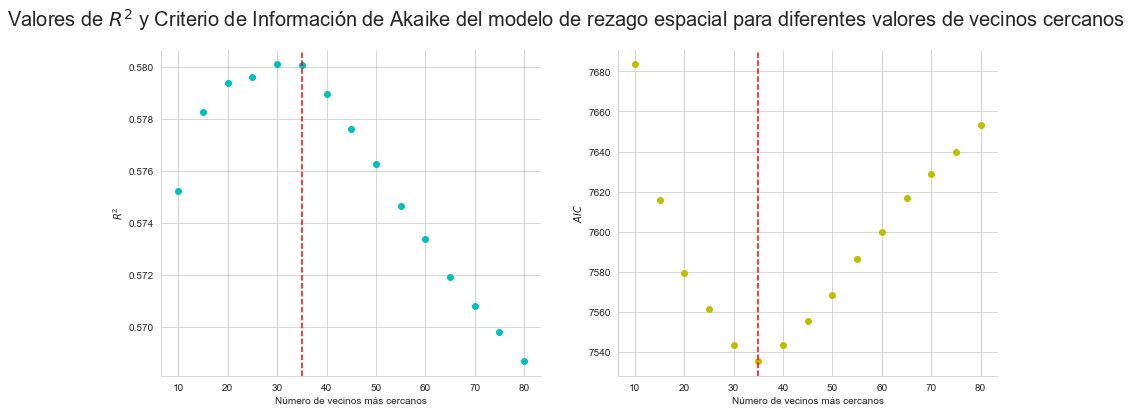

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Valores de $R^2$ y Criterio de Información de Akaike del modelo de rezago espacial para diferentes valores de vecinos cercanos', fontsize=20)
fig.set_figheight(6)
fig.set_figwidth(15)
ax1.scatter(k, ml_r_sq,c = 'c')
ax1.axvline(x=35,c='r', linestyle='--')
ax2.axvline(x=35,c='r', linestyle='--')
ax1.yaxis.set_label_text('$R^2$')
ax2.yaxis.set_label_text('$AIC$')
ax1.xaxis.set_label_text('Número de vecinos más cercanos')
ax2.xaxis.set_label_text('Número de vecinos más cercanos')
ax2.scatter(k, ml_aic, c='y')
sns.despine()
plt.savefig('RAIC.png')

### Selección matriz de 35 vecinos más cercanos

### Modelo OLS para valuar supuestos de normalidad en los errores (Jarque-Bera) e independencia de las observaciones, selección de modelo espacial (SAR -LM LAg, SEM -LM Error)

### MCO tradicional

In [ ]:
### Insertar matriz de varianza-covarianza de White para controlar la heteroscedasticidad  

In [26]:
m_test_ols = spreg.OLS(geo_df2['ln_price'].values[:,None], x_clean.values,robust='white' ,moran=True, w = w35, spat_diag = True ,name_x = x_clean.columns.tolist(), name_y='(log)price')

In [27]:
print(m_test_ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  (log)price                Number of Observations:        6131
Mean dependent var  :      6.6858                Number of Variables   :          22
S.D. dependent var  :      0.6823                Degrees of Freedom    :        6109
R-squared           :      0.4734
Adjusted R-squared  :      0.4716
Sum squared residual:    1502.702                F-statistic           :    261.4874
Sigma-square        :       0.246                Prob(F-statistic)     :           0
S.E. of regression  :       0.496                Log likelihood        :   -4389.134
Sigma-square ML     :       0.245                Akaike info criterion :    8822.268
S.E of regression ML:      0.4951                Schwarz criterion     :    8970.132

White Standard Errors
-------------------------------------------------------

In [178]:
pvals = [i[1] for i in m_test_ols.t_stat]

In [190]:
bets = m_test_ols.betas

In [184]:
pvals = pd.Series(pvals).to_frame()

In [188]:
pvals.index = x.columns.tolist()

In [191]:
pvals['OLS'] = bets

In [198]:
pvals = pvals[['OLS', 0]]

In [200]:
pvals.rename({0:'p-value'}, axis=1, inplace = True)

In [201]:
pvals

,OLS,p-value
const,5.70,0.00
bedrooms,0.06,0.01
bathrooms,0.18,0.00
accommodates,0.14,0.00
insta_book,-0.05,0.00
ad_duration,0.00,0.00
pi_dist,-0.11,0.00
metro_distance,0.09,0.00
parking,0.02,0.11
breakfast,0.03,0.29


In [300]:
w35.transform='V'

# Aplicar modelos Autocorrelación espacial y errores espaciales (SAR y SEM)

# SAR (ML)

In [301]:
ML_mk35 = spreg.ML_Lag(geo_df2['ln_price'].values[:,None], x_clean.values, w = w35,  method='ord',spat_diag=True, name_x=x_clean.columns.tolist(), name_y='ln(price)')


C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\scipy\optimize\_minimize.py:777: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [302]:
print(ML_mk35.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = ORD)
----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   ln(price)                Number of Observations:        6131
Mean dependent var  :      6.6858                Number of Variables   :          23
S.D. dependent var  :      0.6823                Degrees of Freedom    :        6108
Pseudo R-squared    :      0.5801
Spatial Pseudo R-squared:  0.4839
Sigma-square ML     :       0.196                Log likelihood        :   -3744.703
S.E of regression   :       0.442                Akaike info criterion :    7535.407
                                                 Schwarz criterion     :    7689.992

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------------------

# SEM (ML)

In [303]:
ML_err_mk35 = spreg.ML_Error(y=geo_df2['ln_price'].values[:,None], x=x_clean.values, w = w35,  method='ord',spat_diag=True, name_x=x_clean.columns.tolist(), name_y='ln(price)')

In [304]:
print(ML_err_mk35.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = ORD)
------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   ln(price)                Number of Observations:        6131
Mean dependent var  :      6.6858                Number of Variables   :          22
S.D. dependent var  :      0.6823                Degrees of Freedom    :        6109
Pseudo R-squared    :      0.4620
Sigma-square ML     :       0.191                Log likelihood        :   -3709.381
S.E of regression   :       0.437                Akaike info criterion :    7462.762
                                                 Schwarz criterion     :    7610.627

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------------------------------------------------

# Análisis residuales 

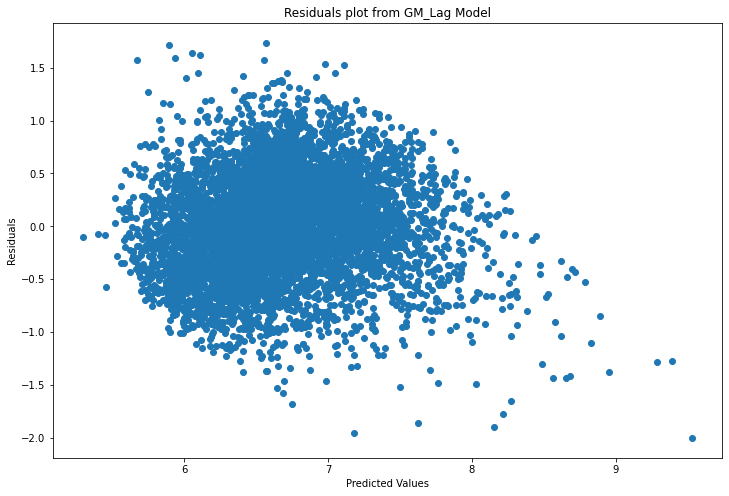

In [105]:
plt.figure(figsize=(12,8))
plt.scatter(GM_mk35.predy, GM_mk35.e_pred); # print resids vs predictions
plt.title("Residuals plot from GM_Lag Model")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.savefig('LR_Residual_Plot')

### En caso de que no se cumpla el supuesto de normalidad en los errores, aplicar método de momentos, computación más sencilla y robusto a errores no normales.

# SAR (GM) Matriz inversa cutoff

In [123]:
GM_id_c = spreg.GM_Lag(geo_df2['ln_price'].values[:,None], x_clean.values, w = w_id_f, robust='white' ,spat_diag=True, name_x=x_clean.columns.tolist(), name_y='ln(price)', name_w='Matriz inversa normalizada con cutoff')

In [124]:
print(GM_id_c.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :Matriz inversa normalizada con cutoff
Dependent Variable  :   ln(price)                Number of Observations:        6131
Mean dependent var  :      6.6858                Number of Variables   :          25
S.D. dependent var  :      0.6823                Degrees of Freedom    :        6106
Pseudo R-squared    :      0.4759
Spatial Pseudo R-squared:  0.4736

White Standard Errors
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       5.2371619       0.1112752      47.0649691       0.0000000
            bedrooms       0.0649393       0.0231650       2.8033321       0.0050578
           b

# SAR Inverse squared distance

In [140]:
GM_id_sq = spreg.GM_Lag(geo_df2['ln_price'].values[:,None], x_clean.values, w = w_id_sq, robust='white' ,spat_diag=True, name_x=x_clean.columns.tolist(), name_y='ln(price)', name_w='Matriz inversa normalizada con cutoff')

In [141]:
print(GM_id_sq.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :Matriz inversa normalizada con cutoff
Dependent Variable  :   ln(price)                Number of Observations:        6131
Mean dependent var  :      6.6858                Number of Variables   :          25
S.D. dependent var  :      0.6823                Degrees of Freedom    :        6106
Pseudo R-squared    :      0.4651
Spatial Pseudo R-squared:  0.4644

White Standard Errors
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       5.4005342       0.1111629      48.5821847       0.0000000
            bedrooms       0.0626090       0.0232011       2.6985349       0.0069645
           b

# SAR (GM) KNN 35

In [102]:
GM_mk35 = spreg.GM_Lag(geo_df2['ln_price'].values[:,None], x_clean.values, w = w35, robust='white' ,spat_diag=True, name_x=x_clean.columns.tolist(), name_y='ln(price)', name_w='KNN weight matrix (k=35)')

In [205]:
print(GM_mk35.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :KNN weight matrix (k=35)
Dependent Variable  :   ln(price)                Number of Observations:        6131
Mean dependent var  :      6.6858                Number of Variables   :          23
S.D. dependent var  :      0.6823                Degrees of Freedom    :        6108
Pseudo R-squared    :      0.5799
Spatial Pseudo R-squared:  0.4850

White Standard Errors
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       1.2338380       0.1840364       6.7043160       0.0000000
            bedrooms       0.0660542       0.0215771       3.0613122       0.0022037
           bathrooms     

# Generar tabla resultados

In [206]:
GM_err_mk35.z_stat

[(54.35263504268635, 0.0),
 (2.9421877647974948, 0.0032590225467587245),
 (7.66191394658943, 1.8318237049804853e-14),
 (19.91096750543, 3.269398173319501e-88),
 (-2.557816986222056, 0.010533151041658351),
 (4.679262106568228, 2.879091966672021e-06),
 (-6.145523411377268, 7.970025617620204e-10),
 (2.766464895450158, 0.005666768563134338),
 (3.2648570974427327, 0.0010951931517599353),
 (0.8934605534420115, 0.3716105875131074),
 (4.529959637411772, 5.89949558879842e-06),
 (1.9954534505853416, 0.045993446275367035),
 (6.082431524849741, 1.183734570963511e-09),
 (6.81569583897, 9.380858468136174e-12),
 (-3.476076398284679, 0.0005088073194397435),
 (0.7608842159555684, 0.446726226993548),
 (-7.782482427930521, 7.111508424664052e-15),
 (6.23604063726386, 4.487845638073581e-10),
 (4.590646559964393, 4.418750496269873e-06),
 (-4.22673242903734, 2.371093372068555e-05),
 (1.905380056571825, 0.056730685732256),
 (-3.195341019562328, 0.0013966570587855536),
 (47.66141012964993, 0.0)]

In [211]:
bets_GM = GM_mk35.betas.tolist()

In [207]:
pval_GM = [i[1] for i in GM_mk35.z_stat]

In [220]:
res_GM = pd.Series(bets_GM).to_frame()

In [221]:
res_GM['p-value'] = pval_GM

In [229]:
index_x = x.columns.tolist()

In [230]:
index_x.append('W_ln(price)')

In [232]:
res_GM.index =index_x

In [246]:
pvals.rename(index={'':'variables'}, inplace =True)
res_GM.rename({0:'SAR - KNN(35)'}, axis = 1, inplace = True)
res_GM.rename(index={'':'variables'}, inplace =True)

In [258]:
betas_SEM = GM_err_mk35.betas.tolist()
pval_SEM = [i[1] for i in GM_err_mk35.z_stat]

In [253]:
index_y = x.columns.tolist
index_y.append('lambda')

In [259]:
res_GM_SEM = pd.Series(betas_SEM).to_frame()

In [260]:
res_GM_SEM['p-value'] = pval_SEM

In [262]:
res_GM_SEM.rename(columns={0:'SEM - KNN(35)'}, index = {'':'variables'}, inplace = True)

In [265]:
res_GM_SEM.index = index_y

In [290]:
pd.options.display.float_format = '{:,.4f}'.format

In [291]:
results = pd.concat([pvals, res_GM, res_GM_SEM], axis=1)

In [293]:
results['SAR - KNN(35)'] = results['SAR - KNN(35)'].astype('str')

In [294]:
results['SAR - KNN(35)'] = results['SAR - KNN(35)'].str.replace('[','').str.replace(']','').astype('float')

In [295]:
results['SEM - KNN(35)'] = results['SEM - KNN(35)'].astype('str').str.replace('[','').str.replace(']','').astype('float')

In [296]:
results

,OLS,p-value,SAR - KNN(35),p-value,SEM - KNN(35),p-value
const,5.7012,0.0000,1.2338,0.0000,5.7204,0.0000
bedrooms,0.0567,0.0114,0.0661,0.0022,0.0621,0.0033
bathrooms,0.1782,0.0000,0.1381,0.0000,0.1229,0.0000
accommodates,0.1430,0.0000,0.1407,0.0000,0.1465,0.0000
insta_book,-0.0489,0.0003,-0.0328,0.0069,-0.0306,0.0105
ad_duration,0.0031,0.0000,0.0024,0.0000,0.0024,0.0000
pi_dist,-0.1130,0.0000,-0.0233,0.0000,-0.0930,0.0000
metro_distance,0.0919,0.0000,0.0098,0.1336,0.0518,0.0057
parking,0.0247,0.1086,0.0405,0.0031,0.0442,0.0011
breakfast,0.0321,0.2854,0.0243,0.3469,0.0233,0.3716


In [325]:
results.to_csv('results.csv', encoding = 'latin1')

In [306]:
m_test_ols.ar2

0.47156245965035637

In [308]:
GM_mk35.pr2

0.5799286951470128

In [307]:
GM_err_mk35.pr2

0.4636967075733527

In [320]:
m_test_ols.moran_res[1:]

(77.33442945072557, 0.0)

In [322]:
m_test_ols.lm_lag

(3960.064426057933, 0.0)

In [323]:
m_test_ols.rlm_lag

(296.6048967373437, 1.8091053005141702e-66)

In [321]:
m_test_ols.lm_error

(5766.445408372829, 0.0)

In [324]:
m_test_ols.rlm_error

(2102.9858790522394, 0.0)

# SEM (GM) Inverse Distance

In [125]:
GM_err_id_c = spreg.GM_Error_Het(geo_df2['ln_price'].values[:,None], x_clean.values ,w = w_id_f,name_x=x_clean.columns.tolist(), name_y='ln(price)', name_w='KNN weight matrix (k=45)')

In [126]:
print(GM_err_id_c.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :KNN weight matrix (k=45)
Dependent Variable  :   ln(price)                Number of Observations:        6131
Mean dependent var  :      6.6858                Number of Variables   :          24
S.D. dependent var  :      0.6823                Degrees of Freedom    :        6107
Pseudo R-squared    :      0.4530
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       5.4087395       0.1062088      50.9255527       0.0000000
            bedrooms       0.0627364       0.0229144       2.737855

# SEM (GM) Inverse Distance Squared

In [142]:
GM_err_id_s = spreg.GM_Error_Het(geo_df2['ln_price'].values[:,None], x_clean.values ,w = w_id_sq,name_x=x_clean.columns.tolist(), name_y='ln(price)', name_w='Squared inverse distance matrix with cutoff')

In [143]:
print(GM_err_id_s.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :Squared inverse distance matrix with cutoff
Dependent Variable  :   ln(price)                Number of Observations:        6131
Mean dependent var  :      6.6858                Number of Variables   :          24
S.D. dependent var  :      0.6823                Degrees of Freedom    :        6107
Pseudo R-squared    :      0.4567
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       5.5247508       0.1046898      52.7725583       0.0000000
            bedrooms       0.0675057       0.023

# SEM (GM) KNN (35)

In [106]:
GM_err_mk35= spreg.GM_Error_Het(geo_df2['ln_price'].values[:,None], x_clean.values ,w = w35,name_x=x_clean.columns.tolist(), name_y='ln(price)', name_w='KNN weight matrix (k=35)')

In [108]:
print(GM_err_mk35.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :KNN weight matrix (k=35)
Dependent Variable  :   ln(price)                Number of Observations:        6131
Mean dependent var  :      6.6858                Number of Variables   :          22
S.D. dependent var  :      0.6823                Degrees of Freedom    :        6109
Pseudo R-squared    :      0.4637
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       5.7203801       0.1052457      54.3526350       0.0000000
            bedrooms       0.0621334       0.0211181       2.942187

## Efectos directos, indirectos y totales

In [17]:
from scipy import linalg

In [78]:
rho = ML_mk35.rho

In [79]:
beta = ML_mk35.betas[:-1]

In [80]:
def get_spillover(w, rho):
    
    w_full = sparse.csr_matrix(w.sparse).toarray()
    rho_W = np.multiply(rho,  w_full)
    I = np.identity(w_full.shape[0])
    I_pw = I - rho_W
    I_pW_inv = np.linalg.inv(I_pw)
    
    return I_pW_inv

In [81]:
margins = [np.multiply(spill, b) for b in beta]

In [82]:
DE = [m.diagonal().mean() for m in margins]

In [83]:
IE = [(np.sum(m) - sum(m.diagonal()))/6131 for m in margins]

In [84]:
tedict =  {
    'Variable':x.columns,
    'DE':DE,
    'IE':IE   
} 

In [85]:
efectos = pd.DataFrame.from_dict(tedict).set_index('Variable')

In [86]:
efectos['TE'] = efectos['DE'] + efectos['IE']

In [87]:
efectos

,DE,IE,TE
Variable,,,
const,1.350135,3.195887,4.546023
bedrooms,0.070227,0.166233,0.236459
bathrooms,0.139580,0.330399,0.469980
accommodates,0.138697,0.328308,0.467005
insta_book,-0.032071,-0.075914,-0.107985
ad_duration,0.002464,0.005834,0.008298
pi_dist,-0.021596,-0.051119,-0.072715
metro_distance,0.009344,0.022117,0.031460
parking,0.024650,0.058348,0.082997


In [326]:
efectos.to_csv('efectos.csv', encoding = 'latin1')

In [66]:
dia_sum =sum(margins_cons.diagonal())

In [67]:
off_dia_sum = np.sum(margins_cons) - dia_sum 

In [70]:
IE = off_dia_sum/6131

0.16238176955741804

In [73]:
w35_full.shape[0]

6131

In [27]:
spill = get_spillover(w35, rho)

In [76]:
spill

array([[1.01615774e+00, 1.29488810e-08, 1.51619501e-15, ...,
        5.55971279e-07, 1.61232463e-17, 1.82631194e-04],
       [4.50171062e-09, 1.02420642e+00, 7.21905578e-17, ...,
        1.00688061e-13, 2.81897619e-19, 1.35768651e-08],
       [3.56903447e-14, 8.94492160e-15, 1.03051477e+00, ...,
        2.43147537e-14, 3.06855155e-15, 1.34938182e-16],
       ...,
       [3.47048793e-06, 2.24219717e-12, 8.09448373e-15, ...,
        1.01856348e+00, 1.61363431e-14, 1.26352428e-06],
       [2.05111911e-16, 6.10256296e-17, 1.04126415e-16, ...,
        8.59011357e-14, 1.01471661e+00, 1.72341942e-14],
       [2.70058134e-04, 5.26100914e-08, 6.00557718e-18, ...,
        3.00731031e-07, 1.27711817e-15, 1.02143243e+00]])

In [80]:
margin = np.multiply(spill, beta[2])
margin.diagonal().mean()

0.13543569943022035

In [112]:
x_clean.mean()

bedrooms                 1.455554
bathrooms                1.329962
accommodates             3.337302
ad_duration             16.186322
pi_dist                  1.543618
metro_distance           0.893961
review_scores_rating    95.645409
number_of_reviews       34.965422
dtype: float64

## Tabla estadística descriptiva

In [114]:
data = pd.read_csv('inside_abnb_clean_3.csv', encoding = 'latin1')

In [116]:
x_clean_2 = data[[  
    
                 ### Tamaño y características físicas  ###
                    'bedrooms', 'bathrooms', 'accommodates',
                 ### Características listado ###
                    'insta_book', 'ad_duration',
                 ### Ubicación  #### 
                    'pi_dist', 'metro_distance',
                 ### Amenidades #### 
                    'parking', 'breakfast', 'gym', 'pool', 'hot_tub', 'elevator',
                 ### Reglas ### 
                    'flexible_cancel', 'pets_allowed', 'smoking_allowed',
                  
                 ### Características anfitrión ### 
                    'host_is_superhost', 'Tipo Listado', 'host_identity_verified',
                  
                  ### Reputación ###
                  'review_scores_rating', 'number_of_reviews']]

In [124]:



mean = x_clean_2.mean().to_frame()
sd = x_clean_2.std().to_frame()
min_ = x_clean_2.min().to_frame()
max_ = x_clean_2.max().to_frame()




In [129]:
mean

,0
bedrooms,1.455554
bathrooms,1.329962
accommodates,3.337302
insta_book,0.611972
ad_duration,16.186322
pi_dist,1.543618
metro_distance,0.893961
parking,0.723536
breakfast,0.063285
gym,0.142391


In [136]:
variables  = x_clean.columns.tolist()

In [137]:
x_desr = [
    
    'Número de recámaras',
    'Número de baños',
    'Número de huéspedes alojados',
    'Variable "dummy". 1 si el anfitrión permite reservaciones inmediatas',
    'Antigüedad de la publicación en meses',
    'Distancia al punto de interés más cercano en kilómetros',
    'Distancia a la estación de STC Metro más cercano en kilómetros',
    'Variable "dummy". 1 si existe disponibilidad de estacionamiento',
    'Variable "dummy". 1 si el listado cuenta con servicio de desayuno',
    'Variable "dummy". 1 si el listado cuenta con gimansio',
    'Variable "dummy". 1 si el listado cuenta con piscina',
    'Variable "dummy". 1 si el listado cuenta con tina caliente',
    'Variable "dummy". 1 si el listado cuenta con elevador',
    'Variable "dummy". 1 si la política de vancelación es flexible, 0 si es moderada/estricta',
    'Variable "dummy". 1 si el anfitrión permite mascotas',
    'Variable "dummy". 1 si el anfitrión permite fumar',
    'Variable "dummy". 1 si el anfitrión es superhost$^1$',
    'Varaible "dummy". 1 si el anfitrión cuenta con más de un listado (profesional)',
    'Variable "dummy". 1 si el anfitrión verificó su identidad (teléfono, correo, Facebook)',
    'Calificación general del listado, escala (0-100)',
    'Número de reseñas del listado'

]

In [138]:
desc_dict = {
    'variable':variables,
    'descripción':x_desr  
}

In [140]:
desc = pd.DataFrame.from_dict(desc_dict)

In [144]:
desc.set_index('variable', inplace = True)

In [146]:
tabla = pd.concat([mean, sd,  min_, max_, desc], axis = 1)

In [153]:
tabla.columns = (['Media', 'Desv. est.', 'Mín', 'Máx', 'Descripción'])

In [151]:
pd.options.display.float_format = '{:,.2f}'.format

In [154]:
tabla

,Media,Desv. est.,Mín,Máx,Descripción
variable,,,,,
bedrooms,1.46,0.78,0.00,24.00,Número de recámaras
bathrooms,1.33,0.54,0.00,4.50,Número de baños
accommodates,3.34,1.84,1.00,16.00,Número de huéspedes alojados
insta_book,0.61,0.49,0.00,1.00,"Variable ""dummy"". 1 si el anfitrión permite re..."
ad_duration,16.19,15.20,0.03,94.06,Antigüedad de la publicación en meses
pi_dist,1.54,1.62,0.02,11.82,Distancia al punto de interés más cercano en k...
metro_distance,0.89,1.35,0.01,11.74,Distancia a la estación de STC Metro más cerca...
parking,0.72,0.45,0.00,1.00,"Variable ""dummy"". 1 si existe disponibilidad d..."
breakfast,0.06,0.24,0.00,1.00,"Variable ""dummy"". 1 si el listado cuenta con s..."


In [155]:
tabla.to_csv('estad_desc.csv', encoding='latin1')

In [158]:
data.precio.mean()

1000.1582123633991

In [159]:
data.precio.std()

681.3981483895539

In [160]:
data.precio.min()

152.0

In [164]:
data2.precio.max()

3996.0

In [163]:
data2 = pd.read_csv('inside_abnb_clean_2.csv', encoding ='latin1')